In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
url = 'https://gitlab.procc.fiocruz.br/mave/repo/-/raw/master/Dados/InfoGripe/dados_semanais_faixa_etaria_sexo_virus_sem_filtro_sintomas.csv'
full_df = pd.read_csv(url, sep=';', decimal=',')

In [3]:
def plot_state(s, ax, h=52):
    df = full_df.copy()
    df = df[df['sexo']=='Total']
    df = df[df['Unidade da Federação']==s]
    df = df[df['escala']=='casos']
    obitos = df[df['dado']=='obito']
    obitos_covid = df[df['dado']=='obitocovid']

    y = 2019
    while y>=2016:
        df = obitos[obitos['Ano epidemiológico']==y].copy()
        series = df['Testes negativos']
        series.index = df['Semana epidemiológica'].astype(str)
        ax = series.head(h).plot(label=y,ax=ax)
        y -= 1
    
    df_2020 = obitos[obitos['Ano epidemiológico']==2020]
    df_2020 = df_2020.head(h)
    df_2020.index = df_2020['Semana epidemiológica'].astype(str)
    
    series = obitos_covid['SARS-CoV-2'].head(h)
    series.index = obitos_covid['Semana epidemiológica']
    
    df_2020['obitos_covid'] = series.values
    df_2020.plot.bar(y=['Testes negativos', 'obitos_covid'], label=['2020, agente não espec.','2020, Covid-19'], ax=ax)
    ax.legend()
    ax.set_title(s)
    ax.set_xlabel('Semana epidemiológica de início dos sintomas')

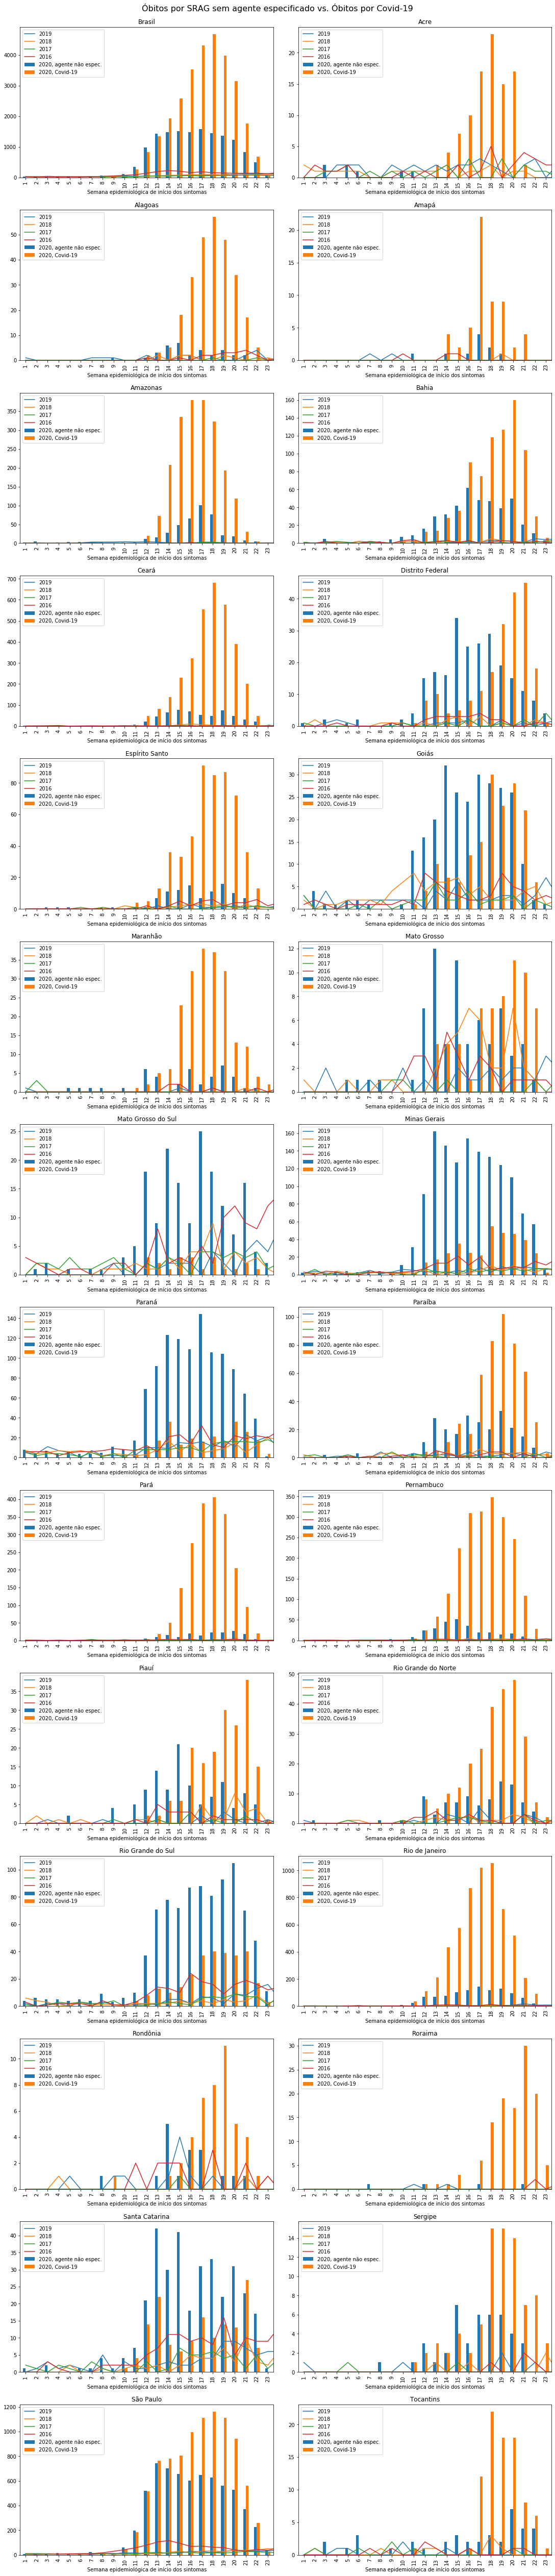

In [4]:
ncols = 2
nrows = 14

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5), constrained_layout=True)
state_names = ['Brasil'] + list(full_df[full_df['Tipo']=='Estado']['Unidade da Federação'].drop_duplicates().sort_values())
for i,s in enumerate(state_names):
    plot_state(s, axes.flat[i])
fig.suptitle('Óbitos por SRAG sem agente especificado vs. Óbitos por Covid-19', fontsize=16);

In [5]:
subnotif_series = pd.Series(index=state_names)
for s in state_names:
    df = full_df.copy()
    df = df[df['sexo']=='Total']
    df = df[df['Unidade da Federação']==s]
    df = df[df['escala']=='casos']
    obitos = df[df['dado']=='obito']
    obitos_covid = df[df['dado']=='obitocovid']

    df = obitos[obitos['Ano epidemiológico']==2020]
    misterio = df['Testes negativos'].fillna(0)
    misterio.index = df['Semana epidemiológica'].astype(str)

    df = obitos[obitos['Ano epidemiológico']==2016]
    explic_parcial = df['Testes negativos'].fillna(0)
    explic_parcial.index = df['Semana epidemiológica'].astype(str)
    explic_parcial = explic_parcial.iloc[:len(misterio)]

    misterio = misterio.sum() - explic_parcial.sum()
    misterio = max(misterio,0)


    covid = obitos_covid['SARS-CoV-2'].fillna(0).sum()

    subnotif = (misterio + covid) / covid
    subnotif_series[s] = subnotif

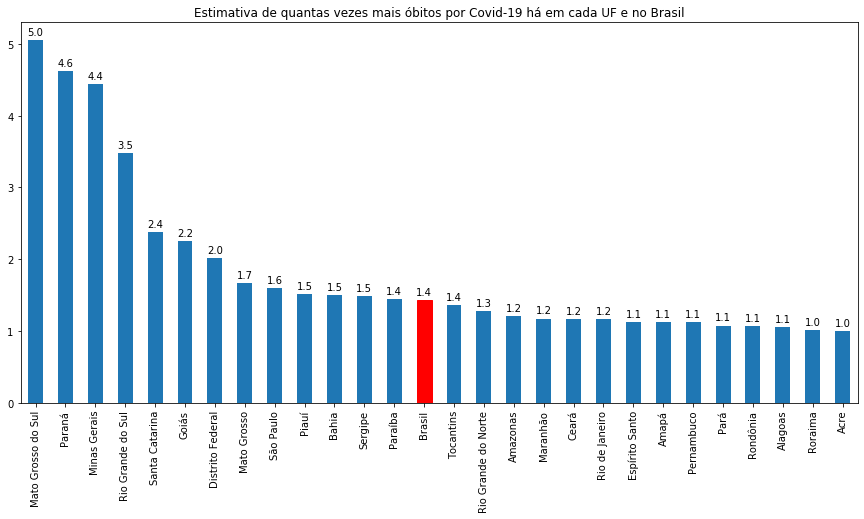

In [6]:
subnotif_series = subnotif_series.sort_values(ascending=False)
ax = subnotif_series.plot(kind='bar', figsize=(15,7))
from matplotlib.patches import Rectangle
rects = [i for i in ax.get_children() if type(i) == Rectangle]
pos_br = subnotif_series.index.get_indexer_for((subnotif_series[subnotif_series.index == 'Brasil'].index))[0]
rects[pos_br].set_color('red')
ax.set_title('Estimativa de quantas vezes mais óbitos por Covid-19 há em cada UF e no Brasil');

# Attach a text label above each bar in *rects*, displaying its height.
for rect in rects[:-1]:
    height = rect.get_height()
    ax.annotate('{:.1f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')